# Temporal Difference Learning



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pdb
import time
from IPython.display import clear_output

np.random.seed(42)
plt.style.use("default")

In [2]:
def animate_robot_movement(env, agent, delay=0.5):
    # Continue until the target is reached
    while env.position != env.target:
        # Display the current state of the environment
        env.display()
        
        # Get the best action for the current state
        best_action = agent.get_optimal_action(env.position)
        
        # Take a step in the environment
        next_state, reward = env.step(best_action)
        
        # Wait for a moment
        time.sleep(delay)
        
        # Clear the output
        clear_output(wait=True)
    
    # Display the final state
    env.display()
    print("Target reached!")

In [3]:
class ValidStateException(Exception):
    pass  
    
class GridWorldEnviroment:
    def __init__(self, size, obstacles, position, target, actions=((0, 0), (1, 0),(-1, 0), (0, 1), (0, -1))):
        self.states = [(x, y) for x in range(size[0]) for y in range(size[1]) if (x,y) not in obstacles] 

        self.size = size 
        
        self.obstacles = obstacles # for plotting purposes
        
        if self.is_valid_state(position):  
            self.initial_position = position # for reset
            self.position = position 
        else: 
            raise ValidStateException
        
        self.target = target 
        self.actions = actions
        
    def is_valid_state(self, state):
        return state in self.states

    def get_reward(self, current_state, action, next_state):
        
        if current_state == self.target:
            return 0
        elif current_state == next_state and action != (0,0):
            return -5
        else:
            return -1

    # this should be modified if we introduce mulfunctioning actuator
    def get_next_state(self, current_state, action):
        possible_next_state = (current_state[0] + action[0], current_state[1] + action[1])
        if self.is_valid_state(possible_next_state) and current_state != self.target:
            next_state = possible_next_state
        else: 
            next_state = current_state
            
        return next_state
            
    def step(self, action):
        current_state = self.position
        next_state = self.get_next_state(current_state, action)
        reward = self.get_reward(current_state, action, next_state)
        self.position = next_state 
        return next_state, reward


    def reset(self):
        self.position = self.initial_position
        return self.position
        
    def display(self):
        # Create a grid initialized to white (empty cells)
        grid = np.ones((self.size[0], self.size[1], 3))

        # Set obstacles to black
        for obstacle in self.obstacles:
            grid[obstacle] = [0, 0, 0]  # Black color

        # Set target to green
        grid[self.target] = [0, 1, 0]  # Green color

        # Set agent's position to blue
        grid[self.position] = [0, 0, 1]  # Blue color

        # Display the grid
        plt.imshow(grid)
        plt.xticks(range(self.size[1]))
        plt.yticks(range(self.size[0]))
        # Shift grid lines to the left and up by 0.5
        ax = plt.gca()
        ax.set_xticks(np.arange(-.5, self.size[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.size[0], 1), minor=True)
        plt.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

        plt.show()

### Initialize the Environment

In [4]:
size = (10, 10)
obstacles = [(0,1), (0,2), (1, 1), (1,2), (2,2), (3,2), (4,2), (5,3), (6,4), (7,5), (8,6), (4,6), (3,6), (9,8), (8,8), (7,8), (6,8), (5,8), (4,8), (4,7)]
position = (0, 0)
target = (9, 9)

env = GridWorldEnviroment(size=size,
                          obstacles=obstacles,
                          position=position,
                          target=target)

training_episodes = 5000
plot_frequency = 50

### Sarsa Agent

In [5]:
class SarsaAgent:
    def __init__(self, env: GridWorldEnviroment,
                 discount_factor=1, alpha=0.5, epsilon=0.5, min_alpha=0.1, min_epsilon=0.1):
        self.env = env
        
        self.discount_factor = discount_factor
        
        # Initial values for alpha and epsilon
        self.alpha = alpha
        self.epsilon = epsilon
        
        # Minimum values for alpha and epsilon
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon

        self.actions = self.env.actions # stay, up, down, right, left
        
        self.q_value_table = self.initialize_q_values() 

        # no need for a policy table, since the actions are taken greedily from Q

        # Initialize list for storing cumulative returns for plotting purposes
        self.cumulative_returns = []
        
    def initialize_q_values(self):
        # Initialize q value function for all states-action pair
        values = np.full(self.env.size+(len(self.actions),), 0.0, dtype=float) # attention: should be float
        # # Set value to 0 for admissible states
        # for state in self.env.states:
        #     values[state] = 0
        return values
        
        
    def get_epsilon_greedy_action(self, state):
        if np.random.uniform(0, 1) >= self.epsilon:
            action = self.get_greedy_action(state)
        else: 
            action_idx = np.random.choice(range(len(self.actions)))
            action = self.actions[action_idx]
        return action

    def get_greedy_action(self, state):
        action_idx = np.argmax(self.q_value_table[state])
        action = self.actions[action_idx]
        return action

    def get_optimal_action(self, state):
        return self.get_greedy_action(state)
        
    def learn(self, state, action, reward, next_state, next_action):

        # prediction = Q(S,A)
        prediction = self.q_value_table[state + (self.actions.index(action),)] 
        
        # target = R + gamma * Q(S',A')
        target = reward + self.discount_factor * self.q_value_table[next_state + (self.actions.index(next_action),)] 
        
        td_error = target - prediction

        # update:  Q(S,A) = Q(S,A) + alpha * td_error
        self.q_value_table[state + (self.actions.index(action),)] += self.alpha * td_error 

    def train(self, episodes, plot=True):

        for episode in range(1, episodes + 1):
            
            # Update alpha and epsilon with decay, but not less than their minimum values
            self.epsilon = max(self.min_epsilon, 1/episode)
            self.alpha = max(self.min_alpha, 1/episode)
            
            state = self.env.reset()  # Reset environment for a new episode
            action = self.get_epsilon_greedy_action(state)

            total_reward = 0  # Initialize the return for the episode to 0

            while True:
                next_state, reward = self.env.step(action)
                next_action = self.get_epsilon_greedy_action(next_state)
                self.learn(state, action, reward, next_state, next_action)

                total_reward += reward  # Accumulate reward

                state = next_state 
                action = next_action

                if state == self.env.target:
                    break

            # Store cumulative return for this episode
            self.cumulative_returns.append(total_reward)
            
            if plot and episode % plot_frequency == 0:
                # Clear the output
                clear_output(wait=True)
            
                # Update plot after each episode
                self.update_plot(episode)

    def get_value_table(self):
        # Assuming q_value_table is a 3D numpy array with dimensions [x, y, action]
        value_table = np.max(self.q_value_table, axis=2)
        return value_table

    def plot_value_table(self):
        # Plot Optimal Value Function and Optimal Policy
        value_table_processed = np.nan_to_num(self.get_value_table(), nan=5*min(self.get_value_table()[0]))
        plt.imshow(value_table_processed, cmap='hot', interpolation='nearest', vmin=2*min(self.get_value_table()[0]))
        plt.colorbar()
        plt.title('Heatmap of Gridworld State Values')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        
        # Define the axis for plotting
        ax = plt.gca()
        
        # Plot the policy
        for i in range(env.size[0]):
            for j in range(self.env.size[1]):
                if (i, j) in self.env.obstacles:
                    continue
                best_action = self.get_optimal_action((i, j))
                if best_action == (0, 0):
                    # Stay action, plot a circle
                    circle = plt.Circle((j, i), 0.1, color='blue', zorder=5)  # Adjusted y coordinate            
                    ax.add_patch(circle)
                else:
                    # Plot an arrow for the action
                    dx, dy = best_action[1], -best_action[0]  # Adjust direction for matrix coordinate system
                    # Flip the dy value to correct the orientation
                    plt.arrow(j, i, dx*0.3, -dy*0.3, color='blue', head_width=0.1, head_length=0.1, zorder=5)  # Adjusted y coordinate and dy
                    
        plt.show()

    def update_plot(self, episode):
        plt.figure(figsize=(10, 6))
        plt.plot(self.cumulative_returns, label='Cumulative Return')
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Return')
        plt.title('Cumulative Return per Episode')
        plt.legend()
        plt.show()
        # Clear the figure to prevent overlapping of plots
        plt.close()

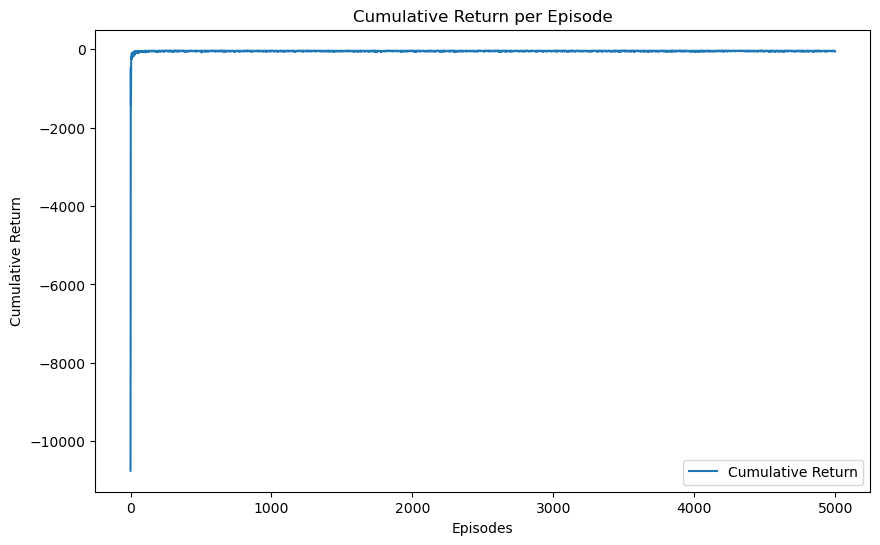

Average return: -48.4626
Minimum return: -80


In [6]:
# Initialize and Train the SarsaAgent
env.reset()
sarsa_agent = SarsaAgent(env) 
sarsa_agent.train(training_episodes)
print(f'Average return: {np.mean(sarsa_agent.cumulative_returns)}')
print(f'Minimum return: {np.min(sarsa_agent.cumulative_returns[100:])}')

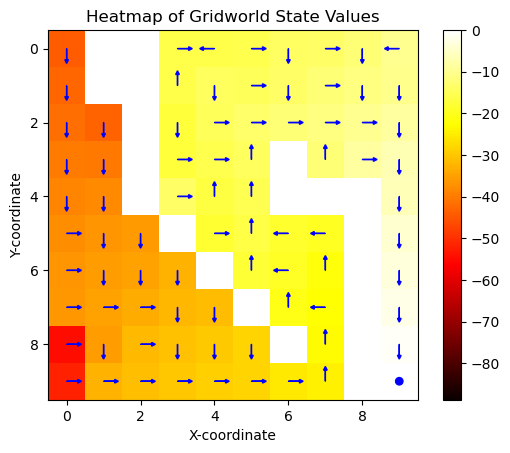

In [7]:
sarsa_agent.plot_value_table()

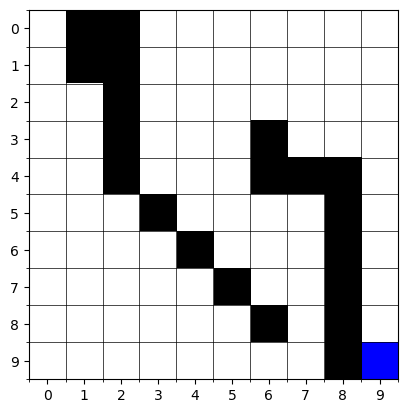

Target reached!


In [8]:
# Test the QLearningAgent
env.reset()
animate_robot_movement(env, sarsa_agent, delay=0.01)

### Q-Learning Agent

In [9]:
class QLearningAgent(SarsaAgent):
    def __init__(self, env, discount_factor=1, alpha=0.5, epsilon=0.5, min_alpha=0.1, min_epsilon=0.1):
        super().__init__(env, discount_factor, alpha, epsilon, min_alpha, min_epsilon)
    
        
    def learn(self, state, action, reward, next_state, debug):

        # prediction = Q(S,A)
        prediction = self.q_value_table[state + (self.actions.index(action),)] 
        
        # target = R + gamma * max_a Q(S',a)
        next_action_greedy = self.get_greedy_action(next_state)

        target = reward + self.discount_factor * self.q_value_table[next_state + (self.actions.index(next_action_greedy),)] 
        td_error = target - prediction


        # print(f't1:{target}')
        
        # target2 = reward + self.discount_factor * np.max(self.q_value_table[next_state])
        # print(f't2:{target2}\n')
        # 
        

        # update:  Q(S,A) = Q(S,A) + alpha * td_error
        #old_value = self.q_value_table[state + (self.actions.index(action),)]
        self.q_value_table[state + (self.actions.index(action),)] = self.q_value_table[state + (self.actions.index(action),)]+ self.alpha * td_error
        new_value = self.q_value_table[state + (self.actions.index(action),)]
        
        if debug:
            print(f"s:{state}, a:{action}, r:{reward}, s':{next_state}, a':{next_action_greedy}")
            print(f"prediction: {prediction},\t target:{target},\t td_error:{td_error}") 
            pdb.set_trace()
            
    def train(self, episodes, plot=True, debug=False):

        for episode in range(1, episodes + 1):
            
            # Update alpha and epsilon with decay, but not less than their minimum values
            self.epsilon = max(self.min_epsilon, 1/episode)
            self.alpha = max(self.min_alpha, 1/episode)
            
            state = self.env.reset()  # Reset environment for a new episode
            total_reward = 0  # Initialize the return for the episode to 0

            while True:
                action = self.get_epsilon_greedy_action(state)
                next_state, reward = self.env.step(action)
                self.learn(state, action, reward, next_state, debug)

                total_reward += reward  # Accumulate reward

                state = next_state               
                
                if state == self.env.target:
                    break

            # Store cumulative return for this episode
            self.cumulative_returns.append(total_reward)
            
            if plot and episode % plot_frequency == 0:
                # Clear the output
                clear_output(wait=True)
            
                # Update plot after each episode
                self.update_plot(episode)

    def get_optimal_action(self, state):
        return self.get_greedy_action(state)

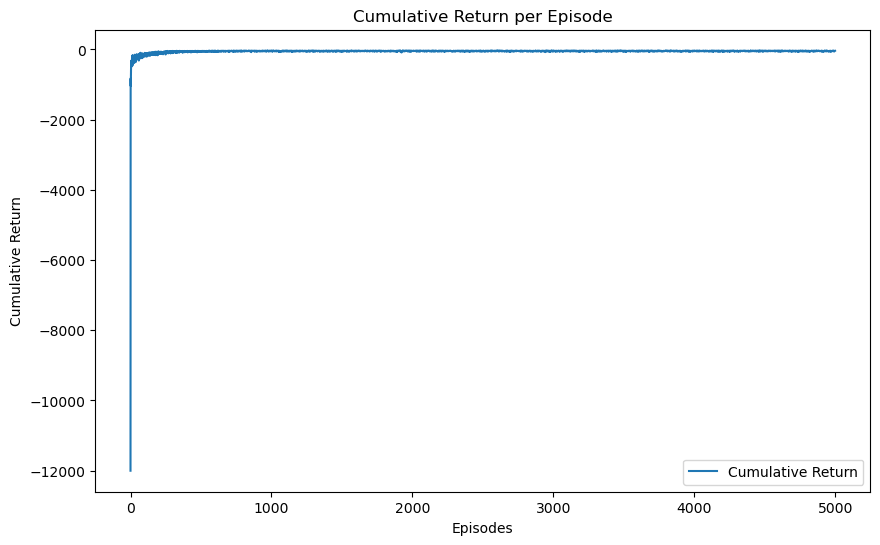

Average return: -53.7602
Minimum return: -80


In [10]:
# Initialize and Train the QLearningAgent
env.reset()
q_learning_agent = QLearningAgent(env) 
q_learning_agent.train(training_episodes)
print(f'Average return: {np.mean(q_learning_agent.cumulative_returns)}')
print(f'Minimum return: {np.min(sarsa_agent.cumulative_returns[100:])}')

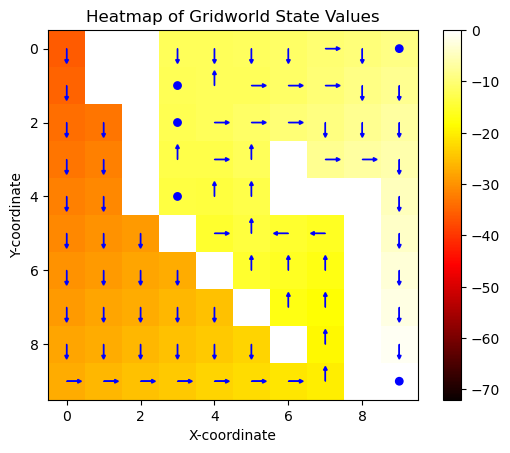

In [11]:
q_learning_agent.plot_value_table()

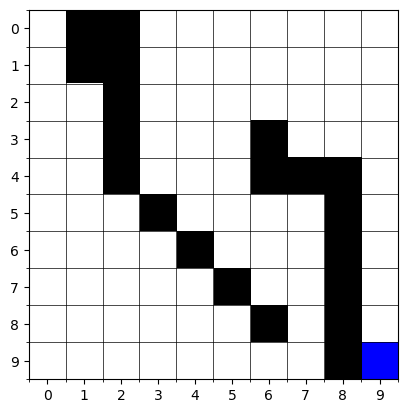

Target reached!


In [13]:
# Test the QLearningAgent
env.reset()
animate_robot_movement(env, q_learning_agent, delay=0.001)